### Hyperparameter optimization for underwater data

In [2]:
%load_ext autoreload
%autoreload 2
# Scipy
import scipy.io as sio
# JAX
import jax
import jax.numpy as jnp
import jax.random as jr
jax.config.update("jax_enable_x64", True)
# GP stuff
import optax as ox
import gpjax as gpx
import cola
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib widget
sns.set()
# HGP
from fasthgp.hgp import HGP
from fasthgp.shgp import SHGP
from fasthgp.kernels import LaplaceBF, SE
key = jr.PRNGKey(13)
# Random convenience
from tqdm.notebook import tqdm

In [6]:
# Load pre-curated data
data = sio.loadmat("data/underwater.mat")
from pyproj import Transformer, CRS
llh_to_xyz = Transformer.from_crs("+proj=latlong +datum=WGS84", "+proj=geocent +datum=WGS84")
xp, yp = llh_to_xyz.transform(data['p1_train'], data['p2_train']) # Project to Cartesian
X = jnp.hstack([xp, yp])
y = data['y_train']
D = gpx.Dataset(X[::50], y[::50])
boundary = jnp.array([D.X.min(axis=0), D.X.max(axis=0)])
# Normalize and center the data
D = D.replace(y=(D.y - D.y.mean())/D.y.std(), X=D.X - boundary.mean(axis=0))

#### Split the data into multiple data sets (you'll run out of memory due to JAX vectorization otherwise)

In [7]:
Ds = []
k = 0
for i in range(1000, D.n, 1000):
    Ds.append(gpx.Dataset(D.X[k:i], D.y[k:i]))
    k = i
Ds.append(gpx.Dataset(D.X[k:], D.y[k:]))

In [8]:
boundary = jnp.array([D.X.min(axis=0), D.X.max(axis=0)])
hgp_boundary = boundary + jnp.array([[-1], [1]]) * jnp.diff(boundary, axis=0)*0.1
L = jnp.diff(hgp_boundary, axis=0) / 2
# Number of basis functions for each dimension
m_d = (40., 40.)

In [9]:
bf = LaplaceBF(num_bfs=m_d, L=L)
kernel = SE(lengthscale=200., variance=1.)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=1.)
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
shgp = SHGP(prior, likelihood, bf=bf) # Structure exploiting HGP
for Di in tqdm(Ds):
    shgp = shgp.update_with_batch(Di) # Pre-compute the precision matrix

  0%|          | 0/14 [00:00<?, ?it/s]

In [10]:
import jax.scipy as jsp
from gpjax.typing import ScalarFloat
from cola.linalg.decompositions.decompositions import Cholesky

# HGP objective (i.e. MLL -- utilizes pre-computed stuff)
class HGPobjective(gpx.objectives.AbstractObjective):
    def step(self, model: HGP, train_data: gpx.Dataset) -> ScalarFloat:
        B = model.B
        s2 = model.likelihood.obs_stddev**2
        lambda_j = model.bf.eigenvalues()
        S = jax.vmap(model.prior.kernel.spectral_density, 0, 0)(jnp.sqrt(lambda_j))
        Lambdainv = jnp.diag(1/S)
        Z = s2 * Lambdainv + B
        Z += cola.ops.I_like(Z) * model.prior.jitter
        Z = cola.PSD(Z)
        # Z = cola.PSD(s2 * Lambdainv + B)
        # Zinv = cola.linalg.inv(Z)
        logdetZ = cola.linalg.logdet(Z, Cholesky())
        # ZR, _ = jsp.linalg.cho_factor(Z, lower=True)
        # logdetZ = 2 * jnp.log(ZR.diagonal()).sum()
        logdetQ = (train_data.n - model.M) * jnp.log(s2) + logdetZ + jnp.log(S).sum()
        aZa = model.alpha.T @ cola.solve(Z, model.alpha, Cholesky())
        # ZRalpha = jsp.linalg.cho_solve((ZR, True), model.alpha)
        # aZa = ZRalpha.T @ ZRalpha
        yTy = train_data.y.T @ train_data.y
        yTQy = 1/s2 * (yTy - aZa)
        const = train_data.n * jnp.log(2 * jnp.pi)
        return 1/2 * (logdetQ + yTQy + const).squeeze()
objective = jax.jit(HGPobjective(negative=True))

In [11]:
opt_shgp, history = gpx.fit(model=shgp,
                           objective=objective,
                           train_data=D,
                           optim=ox.adam(learning_rate=1e-1),
                           num_iters=50,
                           key=key)

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
# The parameters you get here will depend on your subsampling, the number of basis functions along each dimension etc.
# We used 80 x 80, no subsampling, 100 iterations -- but this takes a lot of time.
print(opt_shgp.likelihood)
opt_shgp.prior

Gaussian(num_datapoints=13834, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.21963064, dtype=float32))


Prior(kernel=SE(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(194.67065, dtype=float32), variance=Array(1.1672335, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)

#### Plots only for preliminary purposes (timing and prediction plots were produced in MATLAB)

In [13]:
x, y = [jnp.linspace(*tmp, 100) for tmp in jnp.array([D.X.min(axis=0), D.X.max(axis=0)]).T]
X, Y = jnp.meshgrid(x, y)
Z = jnp.array([X.flatten(), Y.flatten()]).T
yhat,_ = opt_shgp.predict(Z)

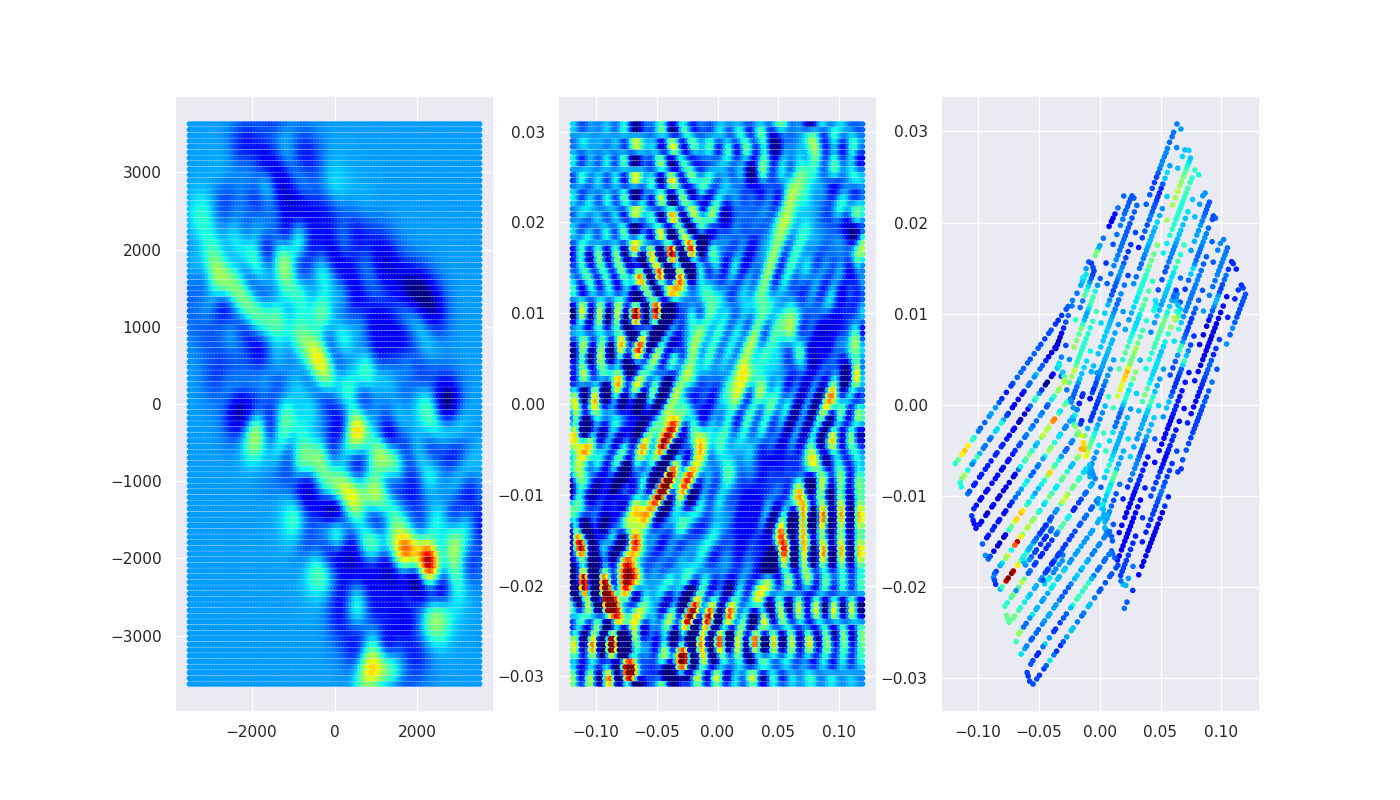

In [272]:
plt.close("all")
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
vmin, vmax = D.y.min(), D.y.max()
ax[0].scatter(Z[:,0], Z[:,1], c=yhat.mean(), vmin=vmin, vmax=vmax, cmap="jet", marker='.')
ax[1].scatter(D.X[::10,0], D.X[::10,1], c=D.y[::10], vmin=vmin, vmax=vmax, cmap="jet", marker='.')
plt.show()

##### Full GP -- you need to subsample quite a lot for this ...

In [125]:
posterior = prior * likelihood 
opt_gp, history = gpx.fit(model=posterior, 
                          objective=jax.jit(gpx.objectives.ConjugateMLL(negative=True)),
                          train_data=D,
                          optim=ox.adam(learning_rate=1e-1),
                          num_iters=30,
                          key=key)

  0%|          | 0/100 [00:00<?, ?it/s]

In [144]:
opt_gp

ConjugatePosterior(prior=Prior(kernel=SE(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(290.21576, dtype=float32), variance=Array(4.52417331, dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=1730, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.28834856, dtype=float64)), jitter=1e-06)

In [141]:
import cola
import jax.numpy as jnp
from gpjax.distributions import GaussianDistribution
train_data = D
x, y = train_data.X, train_data.y
Kxx = opt_gp.prior.kernel.gram(x)
Kxx += cola.ops.I_like(Kxx) * opt_gp.jitter

# Σ = Kxx + Io²
Sigma = Kxx + cola.ops.I_like(Kxx) * opt_gp.likelihood.obs_stddev**2
Sigma_inv = jnp.linalg.inv(Sigma.to_dense()) # Obviously not a "good way" of doing this, but due to the sheer number of prediction locations, this is most efficient
# Sigma_inv = cola.inv(Sigma).to_dense()
mx = opt_gp.prior.mean_function(x)
e = y - mx

def gp_predict(gp, xtest):
    mean_t = gp.prior.mean_function(xtest)
    Ktt = gp.prior.kernel.gram(xtest)
    Kxt = gp.prior.kernel.cross_covariance(x, xtest)
    Sigma_inv_Kxt = Sigma_inv @ Kxt
    
    # μt  +  Ktx (Kxx + Io²)⁻¹ (y  -  μx)
    mean = mean_t + jnp.matmul(Sigma_inv_Kxt.T, e)
    
    # Ktt  -  Ktx (Kxx + Io²)⁻¹ Kxt, TODO: Take advantage of covariance structure to compute Schur complement more efficiently.
    covariance = Ktt - jnp.matmul(Kxt.T, Sigma_inv_Kxt)
    covariance += cola.ops.I_like(covariance) * gp.prior.jitter
    covariance = cola.PSD(covariance)
    
    return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), covariance)